In [1]:
# -*- coding: utf-8 -*-
import time
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://huggingface.co/datasets/thuml/UTSD
# https://github.com/thuml/Large-Time-Series-Model/tree/main

ds = datasets.load_dataset("thuml/UTSD", "UTSD-1G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-2G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-4G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-12G")

all = ds["train"]
print(f'total {len(all)} single-variate series')
print(all[0].keys())

for k, v in all[0].items():
    print(f'{k}: {type(v)}')
    if k == 'target':
        print(f'    {v[:10]}')
    else:
        print(f'    {v}')

total 68679 single-variate series
dict_keys(['item_id', 'start', 'end', 'freq', 'target'])
item_id: <class 'str'>
    Health_SelfRegulationSCP1_458_0
start: <class 'str'>
    
end: <class 'str'>
    
freq: <class 'str'>
    
target: <class 'list'>
    [-8.119999885559082, -11.5600004196167, -14.279999732971191, -18.190000534057617, -20.030000686645508, -20.84000015258789, -20.09000015258789, -19.5, -18.059999465942383, -17.25]


In [3]:
# energy - wind farm : 68547
data = all[68547]['target']
data_len = len(data)
df_Energy_wind = pd.DataFrame({"points":list(range(data_len)),"Power(kW)":data})
df_Energy_wind.head()

,points,Power(kW)
0,0,18.6
1,1,18.6
2,2,18.6
3,3,18.6
4,4,18.6


## Moving Average to denoise data

In [4]:
# 5 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_5'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=5,   # 視窗長度 5 筆
             min_periods=1)  # 前幾筆不足 5 也先算平均，避免 NaN
    .mean()
)


# 10 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_10'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=10,
             min_periods=1)
    .mean()
)



# 20 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_20'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=20,
             min_periods=1)
    .mean()
)

In [5]:
# 定義上下文區間
window_size = 50
stride = 2
max_point = 28000

#訓練參數
p, d, q   = 5, 2, 2

#存檔參數
model_name = f"arima_energyfarm_p5d2q2_0619"

In [6]:
# 定義資料範圍
data_samples = np.array(df_Energy_wind['moving_ave_20'].to_list()[:max_point])

In [7]:
# 切分訓練 / 驗證
split = int(len(data_samples)*0.8)
train, test = data_samples[:split], data_samples[split:]

print(f"train.shape, test.shape = {train.shape}, {test.shape}")

train.shape, test.shape = (22400,), (5600,)


In [8]:
# 用訓練集擬合一次
model = ARIMA(train, order=(p,d,q))
res   = model.fit()

c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## Multi-step forcast

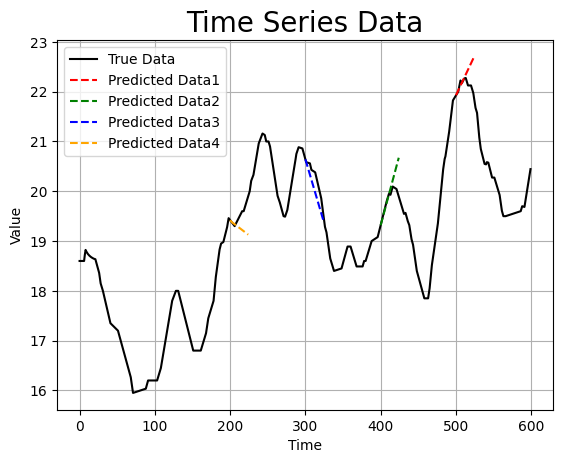

In [9]:
# 每一次重新fit
def fit_and_autoregressive_forecast(window, n_steps):
    _window = window.copy()
    _model = ARIMA(_window, order=(p,d,q))
    _res = _model.fit()
    _preds = _res.forecast(steps=n_steps)
    return np.array(_preds)


# 使用原先的 res 進行fit
def autoregressive_forecast(window, n_steps):
    # 確保有時間索引
    window = pd.Series(window)
    # 用 res.apply(...) 把現有參數套到這段資料
    res_new = res.apply(window, refit=False)
    # 一次預測n點
    preds = res_new.forecast(steps=n_steps)
    return np.array(preds)


# prediction
n_steps = 25
org_test_samples = np.array(df_Energy_wind['moving_ave_20'][:600])
test_samples_1 = org_test_samples[:500]
preds1 = autoregressive_forecast(test_samples_1, n_steps=n_steps)

test_samples_2 = org_test_samples[:400]
preds2 = autoregressive_forecast(test_samples_2, n_steps=n_steps)

test_samples_3 = org_test_samples[:300]
preds3 = autoregressive_forecast(test_samples_3, n_steps=n_steps)

test_samples_4 = org_test_samples[:200]
preds4 = autoregressive_forecast(test_samples_4, n_steps=n_steps)

# 繪製模擬資料+預測資料 PS:迴歸模型普遍現象: 誤差逐步累積
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(org_test_samples)),org_test_samples, label='True Data',c='black')
plt.plot(range(len(test_samples_1),len(test_samples_1)+n_steps), preds1, label='Predicted Data1',c='red', linestyle='--')
plt.plot(range(len(test_samples_2),len(test_samples_2)+n_steps), preds2, label='Predicted Data2',c='green', linestyle='--')
plt.plot(range(len(test_samples_3), len(test_samples_3)+n_steps), preds3, label='Predicted Data3', c='blue', linestyle='--')
plt.plot(range(len(test_samples_4), len(test_samples_4)+n_steps), preds4, label='Predicted Data4', c='orange', linestyle='--')
plt.legend(fontsize=10)
plt.show()

## preds on testing data

In [10]:
# walk-forward：逐點預測，再把真值 append 進來更新狀態
preds = []
res_stream = res
for y_true in test:
    y_hat = res_stream.forecast(steps=1)[0]   # 只花 O(1) 時間
    preds.append(y_hat)

    # 把新觀測附加進模型狀態；refit=False 表示 **不重新估計參數**
    res_stream = res_stream.append([y_true], refit=False)

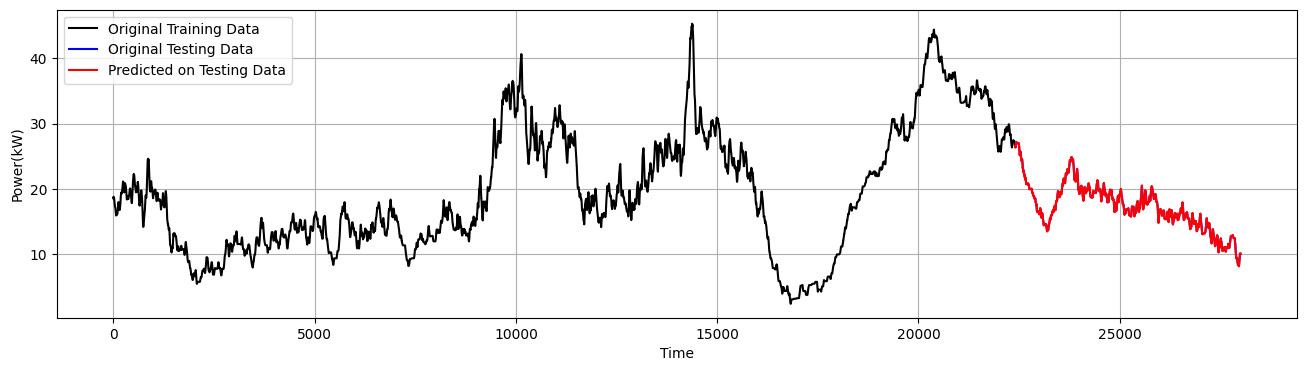

In [11]:
# 繪製模擬資料+預測資料
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Power(kW)')
plt.plot(range(len(train)),train, label='Original Training Data',c='black')
plt.plot(range(len(train),len(train)+len(test)),test, label='Original Testing Data',c='blue')
plt.plot(range(len(train),len(train)+len(test)), preds, label='Predicted on Testing Data',c='red')
plt.legend(fontsize=10,loc='upper left')
plt.show()

## Compute Score

In [12]:
# 計算各項分數
def compute_mae(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    mae = mean_absolute_error(_y_true, _y_pred)
    # mae = np.mean(np.abs(_y_true - _y_pred))
    return mae

def compute_rmse(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    rmse = np.sqrt(mean_squared_error(_y_true, _y_pred))
    return rmse


def compute_r2(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    r2 = r2_score(_y_true, _y_pred)
    return r2

In [13]:
# Testing Data Score
mae_test = compute_mae(test, preds)
rmse_test = compute_rmse(test, preds)
r2_test = compute_r2(test, preds)

print(f"Testing Data Score: MAE = {mae_test:.4f}, RMSE = {rmse_test:.4f}, R² = {r2_test:.4f}")

Testing Data Score: MAE = 0.0071, RMSE = 0.0197, R² = 1.0000


## Print & Export Params

In [14]:
res.params

array([-0.00056865, -0.01376273, -0.04010675, -0.00325778, -0.03381559,
       -0.00035435, -0.01272737,  0.0006088 ])

In [15]:
res.param_names

['ar.L1', 'ar.L2', 'ar.L3', 'ar.L4', 'ar.L5', 'ma.L1', 'ma.L2', 'sigma2']

In [16]:
res.arparams

array([-0.00056865, -0.01376273, -0.04010675, -0.00325778, -0.03381559])

In [17]:
res.maparams

array([-0.00035435, -0.01272737])

In [18]:
res.resid

array([ 1.86000004e+01, -9.30000019e+00,  3.59534624e-12, ...,
       -8.76809736e-12, -4.05471212e-11, -1.20792265e-13])

In [19]:
# 匯出權重: 將必要資訊寫進 model.csv
param_dict = dict(zip(res.param_names, res.params))
mu = param_dict.get('const', 0.0)      # 沒截距時預設 0

out = {
    "order_p": p,
    "order_d": d,
    "order_q": q,
    "mu":      mu,                     # 截距
    "sigma2":  param_dict['sigma2'],      # 噪音變異
    # AR 係數 φ1…φp
    **{f"phi{i+1}": v for i, v in enumerate(res.arparams)},
    # MA 係數 θ1…θq
    **{f"theta{j+1}": v for j, v in enumerate(res.maparams)},
    # 最後 q 個殘差，用來做多步預測
    **{f"eps{j+1}": v for j, v in enumerate(res.resid[-q:][::-1])}
}
pd.Series(out).to_csv("./checkpoints/arima/model_p5d2q2.csv", header=False)

In [20]:
# 匯出預測數據
pd.Series(test_samples_2).to_csv("./checkpoints/arima/input_p5d2q2.csv", header=False, index=False)
print(preds2)

[19.31799407 19.37580911 19.43196108 19.48819693 19.54446933 19.60087567
 19.65728953 19.71375604 19.77021409 19.82666944 19.88311825 19.93956701
 19.99601422 20.05246199 20.10890989 20.16535807 20.22180623 20.27825443
 20.3347026  20.39115077 20.44759893 20.50404708 20.56049524 20.6169434
 20.67339156]


In [21]:
# 讀取C++預測的結果
preds2_cpp = []
with open("./checkpoints/arima/output_p5d2q2.csv", 'r') as f:
    for line in f:
        preds2_cpp.append(float(line.strip()))
print(preds2_cpp)

[19.318, 19.3758, 19.432, 19.4883, 19.5445, 19.601, 19.6574, 19.7139, 19.7704, 19.8268, 19.8833, 19.9398, 19.9962, 20.0527, 20.1091, 20.1656, 20.2221, 20.2785, 20.335, 20.3915, 20.4479, 20.5044, 20.5609, 20.6173, 20.6738]


## Comparison between C++ and Python

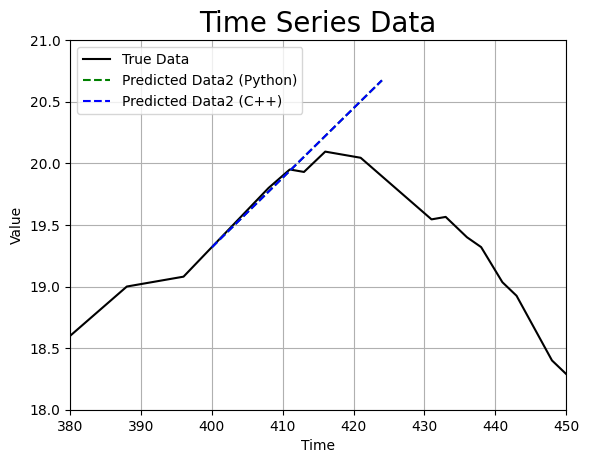

In [ ]:
# 繪製C++預測的結果
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(org_test_samples)),org_test_samples, label='True Data',c='black')
plt.plot(range(len(test_samples_2),len(test_samples_2)+n_steps), preds2, label='Predicted Data2 (Python)',c='green', linestyle='--')
plt.plot(range(len(test_samples_2), len(test_samples_2)+n_steps), preds2_cpp, label='Predicted Data2 (C++)', c='blue', linestyle='--')
# 設定軸範圍
plt.xlim(380, 450)
plt.ylim(18, 21)

plt.legend(fontsize=10, loc='upper left')
plt.show()

In [25]:
#匯出訓練+測試資料
pd.Series(data_samples).to_csv("./checkpoints/arima/data_samples_28k.csv", header=False, index=False)